In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# astropy
from astropy import units as u
from astropy import constants

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

import dynesty

import sklearn
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.gaussian_process import GaussianProcessRegressor

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Classification
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from astroML.utils import split_samples, completeness_contamination

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

## Galaxies vs Quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

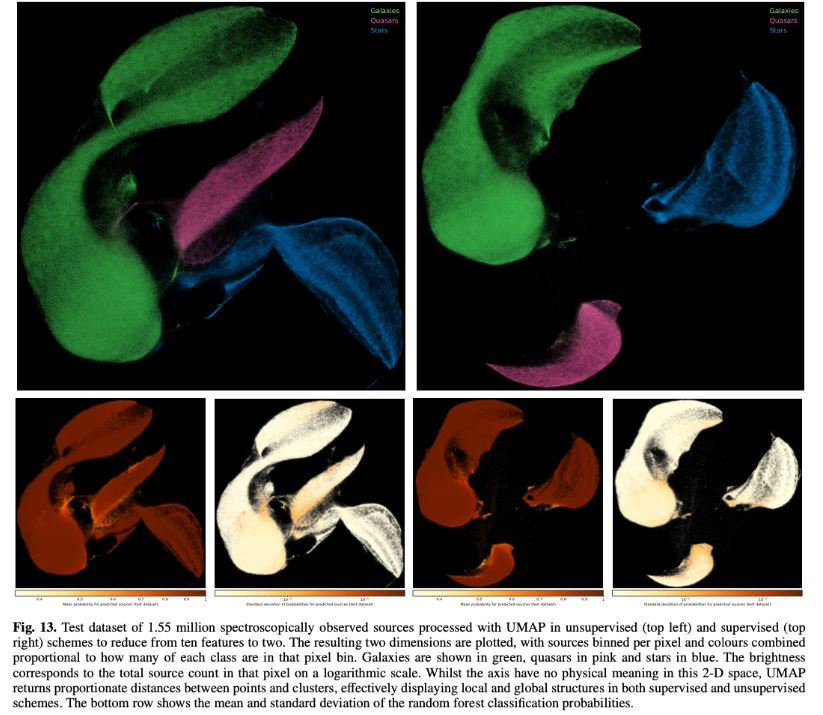

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 
    

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...


In [6]:
# read the data
data = pd.read_csv('galaxyquasar-Copy1.csv')

data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [20]:
# create the color arrays
u_g, g_r, r_i, i_z = np.array([(data['u']-data['g']), (data['g']-data['r']), (data['r']-data['i']), (data['i']-data['z'])])

# assign the 0 to galaxyes and 1 to QSO
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
data['class'] = le.fit_transform(data['class'])
labels = le.inverse_transform(data['class'])
class_names = le.classes_
print(class_names)

data

[0 1]


,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


In [32]:
X = np.array([u_g, g_r, r_i, i_z]).T
y = np.array(data['class'])

X.shape

(50000, 4)

In [33]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.25,train_size=0.75)

#### Gaussian Naive Bayes

In [44]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train,y_train)
y_pred_gnb = gnb_clf.predict(X_test)

In [48]:
confusion_matrix(y_test,y_pred_gnb)

array([[10518,   206],
       [  138,  1638]], dtype=int64)

#### Linear Discriminant Analysis

In [47]:
lda_clf = LDA()
lda_clf.fit(X_train,y_train)
y_pred_lda = lda_clf.predict(X_test)

In [49]:
confusion_matrix(y_test,y_pred_lda)

array([[10616,   108],
       [  122,  1654]], dtype=int64)

#### Quadratic Discriminant Analysis

In [51]:
qda_clf = QDA()
qda_clf.fit(X_train,y_train)
y_pred_qda = qda_clf.predict(X_test)

In [52]:
confusion_matrix(y_test,y_pred_qda)

array([[10596,   128],
       [  129,  1647]], dtype=int64)

#### GMM Bayes Classification

In [57]:
def error_func(y_true, y_m):
    "computes the loss function"
    
    N = len(y_true)
    return np.sqrt(np.sum((y_true-y_m)**2)/N) # implement the division by the sigma?

def cross_validation(X,y,model,split_method):
    "computes and returns the cross validation error and the training error, given the datasets and the model to validate"
    
    split = split_method # sample splitting
    
    err2_train_i = []
    err2_cv_i = []
    
    # iterating over the n_splits
    for train, test in split.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_true_train = y[train]
        
        y_cv = model.predict(X[test])
        y_true_cv = y[test]
        
        # compute the errors on the training and cross-validation set for a given set
        err2_train_i.append((error_func(y_true_train,y_train))**2) # take the square to sum
        err2_cv_i.append((error_func(y_true_cv,y_cv))**2) # take the square to sum
        
    err_train = np.sqrt(np.sum(err2_train_i))
    err_cv = np.sqrt(np.sum(err2_cv_i))
    
    return err_train, err_cv

def compute_GMMbayes(Ncomp,Ncolors):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm, tol=1E-5, covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

In [61]:
gmm_clf = GMMBayes(n_components=2)
gmm_clf.fit(X_train,y_train)
y_pred_gmm = gmm_clf.predict(X_test)

In [ ]:


classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

In [58]:
n_gauss_grid = np.arange(1,10)

err_cv = np.zeros(len(n_gauss_grid))
err_train = np.zeros(len(n_gauss_grid))

for n in n_gauss_grid:
    model = GMMBayes(n)
    
    # cross validation
    n_splits = 5
    split_method = KFold(n_splits=n_splits)
    err_train[n-1], err_cv[n-1] = cross_validation(X,y,model,split_method)
    
print('N_splits:',n_splits)

# normalization of the error
norm_err_cv = err_cv/err_cv.max()
norm_err_train = err_train/err_train.max()

print('Best n_components:',np.argmin(norm_err_cv)+1)

# plot
fig = plt.figure(figsize=(8,8))

plt.plot(n_gauss_grid,norm_err_train,color='black',ls='--',label='training')
#plt.scatter(n_degree,norm_err_train,color='black')
plt.plot(n_gauss_grid,norm_err_cv,color='red',ls='-',label='cross validation')
plt.xlabel('n components')
plt.ylabel('rms')
plt.title('RMS error GMM Bayes')
plt.legend()

AttributeError: 'NoneType' object has no attribute 'split'


##### Food for thought


- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?